# TP OMA 2: Stochastic first order methods
> ## RAMILISON Hugo | REGAIEG Mohamed

## 1 - Linear regression

In this pratical exercise, we will train again a linear regression model as in TP1 but using stochastic first order methods as seen in the lectures.

Recall the following:

In general, linear regression model do not require to solve an optimization model as the solution can be derived by inverting the normal equations (if the problem has the right properties). However, in the large scale setting, the inversion of the system required in the normal equation is not possible and approximate solutions are computeed using first order methods.

Given a matrix $A\in\mathbb{R}^{n\times d}$ and $b\in\mathbb{R}^n$, we want to minimize the following objective function

$$f(x)=\frac{1}{2n}\|Ax-b\|^2=\frac{1}{2n}\displaystyle\sum_{i=1}^n(a_i^\top x -b_i)^2$$

One can see the function $f$ is $\mu$ strongly convex with $\mu=\lambda_{min}(\nabla^2 f(x))=\frac{1}{n}\lambda_{min}(A^T A)$ and $L$ smooth with $L=\lambda_{max}(\nabla^2 f(x))=\frac{1}{n}\lambda_{max}(A^T A)$, since here the Hessian matrix is constant, independent of $x$.

When $A^{T} A$ is invertible, which is the case here, then we have a simple closed form solution for (the unique) $x^* = \text{argmin}_{x \in \mathbb{R}^d} f(x)$. Indeed, solving $\nabla f(x^*) = 0$ leads to $x^* = (A^T A)^{-1} A^T b$. However when $n$ and $d$ are large (which is the case in modern "big data" problems), using this formula is prohibitively expensive from a computational viewpoint, hence the necessity of using first order optimization algorithms.

In the examples used in the following, whenever possible, in order to exhibit the convergence rates, we will also compute $f(x^*)$ using the normal equations ($x^*=(A^T A)^{-1} A^T b$). 

Additionally, we will also consider regularized version of the least square problem in order to enforce some structure in the solution as seen in the lecture as well (ex: L1 regulatrisation for sparsity, L2 for robustness to data perturbation,...).

We will first load some useful packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as math
import sklearn as sk
from sklearn.datasets import make_regression

### Generating data

In order to generate regression datasets, we will use a dataset generation function from the wellknown $\text{scikit-learn}$ machine learning python environment. The function documentation is available at  https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html.

Create (by filling in the code below) a python function that will apply this function in order generate a datasets of $n$ samples of dimension $d$ (number of features).


In [2]:
def generate_dataset(n,d):
    X,Y = make_regression(n, d, n_informative=100, bias=2, coef=False, noise=10.0)
    return X,Y

In [3]:
n=10000
d=10

X,Y=generate_dataset(n,d)
print("X=",X)
print("Y=",Y)

A = np.c_[np.ones(n), X]


X= [[-2.1082724  -1.27990517  1.0968229  ... -0.64525005  0.99278276
  -0.50426197]
 [ 0.17626449  0.17204832  1.31143588 ... -0.50605933  0.33104325
  -1.74109964]
 [-0.31576698  1.08306511 -0.3192093  ... -0.01567884 -0.05623375
   0.42238111]
 ...
 [-0.38866056 -0.86649647  0.97139195 ...  1.00079657  0.26317642
  -1.64647921]
 [ 0.49338486  1.08257438  0.33915332 ... -2.95153888 -1.25473314
   0.04781209]
 [ 0.79164291  0.36063368 -0.457762   ...  0.48097369 -0.32382245
   0.47108282]]
Y= [-101.36205624 -160.01872007  186.48129059 ...  107.49017494  -99.46476664
  -74.15663255]


In [4]:
# Define problem constants
eigenvalues, eigenvectors = np.linalg.eig(A.T @ A)  
c = 1/(n)* np.min(eigenvalues)
L= 1/(n)* np.max(eigenvalues)

### Computing $f(x^*)$

In [5]:
def full_objective(Y, A, x):
    # Compute the least squares objective over the whole dataset
    n= Y.shape[0]
    return 1/(2*n)*np.linalg.norm(Y - A @ x)**2

In [6]:
x_star = np.linalg.solve(A.T@A, A.T@Y)
best_objective = full_objective(Y, A, x_star)
print("f(x*) = ", best_objective)
print(x_star)


f(x*) =  49.36133394790814
[ 2.08991303 72.07480059 45.97103581 85.97531111 94.94316638 34.96525221
 64.99632689 72.03855388 79.9039295  99.25629411 97.82091646]


### Benchmark: gradient descent

In [7]:
def gradient_regression(Y, A, x):
    """
    Compute the gradient of the regression function for the entire dataset.
    
    :param Y: a numpy array of shape (n)
    :param A: a numpy array of shape (n, d)
    :param x: compute the gradient at these parameters, numpy array of shape (d)
    
    :return: gradient: numpy array of shape (d)
    """
    
    n = Y.shape[0]
    grad = - (1/n) * A.T @ (Y - A @ x)
    return grad

def gradient_descent(
        Y, 
        A, 
        initial_x, 
        nmax, lr):
    """
    Gradient Descent for Linear Least Squares problems.
    
    :param Y: numpy array of size (n)
    :param A: numpy array of size (n, d)
    :param initial_x: starting parameters, a numpy array of size (d)
    :param nmax: integer, number of iterations
    :param lr: learning rate=step size
    
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    for epoch in range(nmax):
        grad = gradient_regression(Y, A, x)
        # update x through the gradient update
        x = x - lr * grad
    
        # store x and objective
        xs.append(x.copy())
        objective = full_objective(Y, A, x)
        objectives.append(objective)
        print("GD({ep:04d}/{bi:04d}/{ti:04d}): objective = {l:10.2f}".format(ep=epoch,
                      bi=epoch, ti=len(Y) - 1, l=objective))
    return objectives, xs

import datetime

# Define the parameters of the algorithm.
nmax = 100
lr=0.1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start GD
start_time = datetime.datetime.now()
gd_objectives, gd_iterates = gradient_descent(
    Y, A, x_initial, nmax, lr)
end_time = datetime.datetime.now()

# Print result
execution_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=execution_time))


GD(0000/0000/9999): objective =   24362.62
GD(0001/0001/9999): objective =   19750.92
GD(0002/0002/9999): objective =   16014.70
GD(0003/0003/9999): objective =   12987.63
GD(0004/0004/9999): objective =   10534.98
GD(0005/0005/9999): objective =    8547.67
GD(0006/0006/9999): objective =    6937.33
GD(0007/0007/9999): objective =    5632.39
GD(0008/0008/9999): objective =    4574.88
GD(0009/0009/9999): objective =    3717.86
GD(0010/0010/9999): objective =    3023.27
GD(0011/0011/9999): objective =    2460.31
GD(0012/0012/9999): objective =    2004.01
GD(0013/0013/9999): objective =    1634.14
GD(0014/0014/9999): objective =    1334.32
GD(0015/0015/9999): objective =    1091.28
GD(0016/0016/9999): objective =     894.24
GD(0017/0017/9999): objective =     734.50
GD(0018/0018/9999): objective =     604.98
GD(0019/0019/9999): objective =     499.97
GD(0020/0020/9999): objective =     414.83
GD(0021/0021/9999): objective =     345.78
GD(0022/0022/9999): objective =     289.79
GD(0023/002

### Stochastic gradient descent

Let us first define the gradient function that will be used next in the descent algorithm.

In [8]:
def minibatch_gradient(Y_batch, A_batch, x):
    """
    Compute a mini-batch stochastic gradient from a subset of `num_examples` from the dataset.
    
    :param Y_batch: a numpy array of shape (batch_size)
    :param A_batch: a numpy array of shape (batch_size, d)
    :param x: compute the mini-batch gradient at these parameters, numpy array of shape (d)
    
    :return: stoc_grad: numpy array of shape (d)
    """
    
    stoc_grad = gradient_regression(Y_batch, A_batch, x)
    return stoc_grad


Using your gradient function, propose an implementation of the gradient descent to solve the linear regression problem.

In [9]:
import random as random
def stoc_gradient_descent(
        Y, 
        A, 
        initial_x, 
        nmax, lr, batch_size):
    """
    Stochastic gradient descent for Linear Least Squares problems.
    
    :param Y: numpy array of size (n)
    :param A: numpy array of size (n, d)
    :param initial_x: starting parameters, a numpy array of size (d)
    :param nmax: integer, number of iterations
    :param lr: learning rate=step size
    :param batch_size: number of samples used for calculating the stochastic gradient 
    
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    for epoch in range(nmax):
        n=len(Y)
        batch_set = random.sample(range(n), batch_size)
        # index= np.array(batch_set)
        A_batch = A[batch_set,:]
        Y_batch = Y[batch_set]
        stocgrad= minibatch_gradient(Y_batch, A_batch, x)
        
        # update x through the gradient update
        x = x - lr * stocgrad

        # store x and objective
        xs.append(x.copy())
        objective = full_objective(Y, A, x)
        objectives.append(objective)
        print("SGD({ep:04d}/{bi:04d}/{ti:04d}): objective = {l:10.2f}".format(ep=epoch,
                      bi=epoch, ti=len(Y) - 1, l=objective))
    return objectives, xs

Test now your SGD on the regression problem you have generated earlier. You may try several values for the step size and various type of step sizes (constant, diminishing).

In [10]:
import datetime

# Define the parameters of the algorithm.
nmax = 100
lr=0.05
batch_size=1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start GD
start_time = datetime.datetime.now()
stocgd_objectives, stocgd_iterates = stoc_gradient_descent(
    Y, A, x_initial, nmax, lr,batch_size)
end_time = datetime.datetime.now()

# Print result
execution_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=execution_time))

SGD(0000/0000/9999): objective =   30059.67
SGD(0001/0001/9999): objective =   28883.82
SGD(0002/0002/9999): objective =   13352.61
SGD(0003/0003/9999): objective =   13006.91
SGD(0004/0004/9999): objective =   11937.45
SGD(0005/0005/9999): objective =   10895.68
SGD(0006/0006/9999): objective =   10897.53
SGD(0007/0007/9999): objective =   10628.33
SGD(0008/0008/9999): objective =   10620.57
SGD(0009/0009/9999): objective =    7833.96
SGD(0010/0010/9999): objective =    6564.62
SGD(0011/0011/9999): objective =    5588.57
SGD(0012/0012/9999): objective =    5586.81
SGD(0013/0013/9999): objective =    5005.70
SGD(0014/0014/9999): objective =    4988.98
SGD(0015/0015/9999): objective =    4925.64
SGD(0016/0016/9999): objective =    4799.46
SGD(0017/0017/9999): objective =    4783.31
SGD(0018/0018/9999): objective =    4754.51
SGD(0019/0019/9999): objective =    4680.18
SGD(0020/0020/9999): objective =    4664.54
SGD(0021/0021/9999): objective =    4613.51
SGD(0022/0022/9999): objective =

Let us now plot the convergence profile, i.e. $f(x_t) - f(x^*)$ with respect to the iteration $t$:


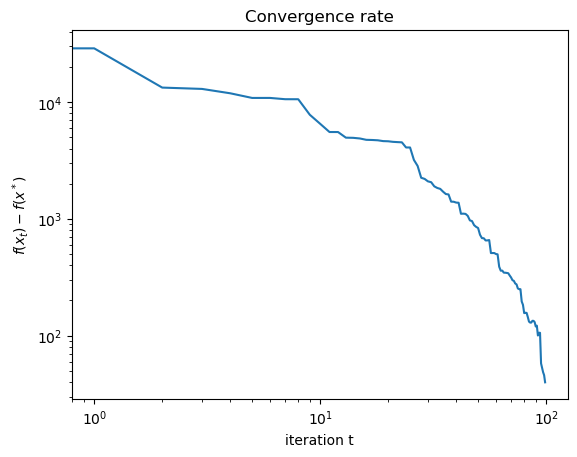

In [11]:
plt.title('Convergence rate')
plt.loglog(stocgd_objectives - best_objective)
plt.xlabel('iteration t')
plt.ylabel(r'$f(x_t) - f(x^*)$')
plt.show()
# test lr comme en cours
# augmente batch size

#### Constant Learning Rate

According to the course results, the constant stepsize must satisfy
$0 < \bar{\alpha} \le \frac{\mu}{L\,M_G}$,
where $L$ is the Lipschitz constant of the gradient and $M_G$ is related to the
variance of the stochastic gradient.

In the context of this TP, the stochastic gradient is unbiased, which implies
$\mu=\mu_G=1$. Moreover, using the variance assumptions, we obtain
$M_G = M_V + \mu_G^2 = M_V + 1$.
Hence, the admissible range for the constant stepsize becomes
$0 < \bar{\alpha} \le \frac{1}{L(1+M_V)}$.

SGD(0000/0000/9999): objective =   21126.71
SGD(0001/0001/9999): objective =   14844.47
SGD(0002/0002/9999): objective =   10998.41
SGD(0003/0003/9999): objective =    7660.46
SGD(0004/0004/9999): objective =    5332.91
SGD(0005/0005/9999): objective =    3572.67
SGD(0006/0006/9999): objective =    2709.89
SGD(0007/0007/9999): objective =    2095.58
SGD(0008/0008/9999): objective =    1453.31
SGD(0009/0009/9999): objective =     971.57
SGD(0010/0010/9999): objective =     707.16
SGD(0011/0011/9999): objective =     490.57
SGD(0012/0012/9999): objective =     344.68
SGD(0013/0013/9999): objective =     245.02
SGD(0014/0014/9999): objective =     188.61
SGD(0015/0015/9999): objective =     139.21
SGD(0016/0016/9999): objective =     109.22
SGD(0017/0017/9999): objective =      90.20
SGD(0018/0018/9999): objective =      78.87
SGD(0019/0019/9999): objective =      71.66
SGD(0020/0020/9999): objective =      67.38
SGD(0021/0021/9999): objective =      60.53
SGD(0022/0022/9999): objective =

SGD(0053/0053/9999): objective =      52.60
SGD(0054/0054/9999): objective =      52.27
SGD(0055/0055/9999): objective =      51.68
SGD(0056/0056/9999): objective =      51.37
SGD(0057/0057/9999): objective =      51.13
SGD(0058/0058/9999): objective =      50.84
SGD(0059/0059/9999): objective =      50.68
SGD(0060/0060/9999): objective =      50.67
SGD(0061/0061/9999): objective =      50.69
SGD(0062/0062/9999): objective =      50.68
SGD(0063/0063/9999): objective =      50.43
SGD(0064/0064/9999): objective =      50.23
SGD(0065/0065/9999): objective =      50.05
SGD(0066/0066/9999): objective =      49.95
SGD(0067/0067/9999): objective =      49.96
SGD(0068/0068/9999): objective =      49.77
SGD(0069/0069/9999): objective =      49.65
SGD(0070/0070/9999): objective =      49.57
SGD(0071/0071/9999): objective =      49.55
SGD(0072/0072/9999): objective =      49.61
SGD(0073/0073/9999): objective =      49.65
SGD(0074/0074/9999): objective =      49.67
SGD(0075/0075/9999): objective =

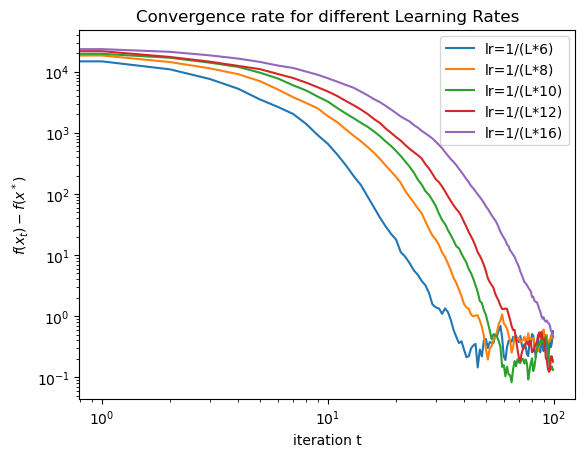

In [27]:
# Define the parameters of the algorithm.
nmax = 100
lr_values = [1/(i*L) for i in [6, 8, 10, 12, 16]]
objectives_dict = {}

for lr in lr_values:
    objectives, _ = stoc_gradient_descent(Y, A, x_initial, nmax, lr, batch_size)
    objectives_dict[lr] = objectives

for lr, objectives in objectives_dict.items():
    # Plot f(x_t) - f(x^*) on log-log scale
    plt.loglog(np.array(objectives) - best_objective,
               label=f"lr=1/(L*{1/(L*lr):.0f})")

plt.legend()
plt.xlabel("iteration t")
plt.ylabel(r"$f(x_t) - f(x^*)$")
plt.title("Convergence rate for different Learning Rates")
plt.show()

We can observe that for **lr = 1/(L*6)** the curve diverges, suggesting that the stepsize condition may not be respected in practice. For smaller values of lr, the objective decreases more steadily. The smaller the learning rate, the smoother the curve is, with fewer oscillations, although the convergence becomes slower.

#### Diminishing Learning Rate 

Following *Optimization Methods for Large-Scale Machine Learning*
(Bottou, Curtis, Nocedal, February 12, 2018), we consider a diminishing
stepsize of the form $\alpha_k = \frac{\beta}{\gamma + k}$, with
$\beta > \frac{1}{c\mu}$ and $\gamma > 0$. In addition, the initial
stepsize must satisfy $\alpha_1 < \frac{\mu}{L M_G}$ in order to meet
the theoretical convergence conditions.

In [13]:
import random as random
def stoc_gradient_descent_diminishing_lr(
        Y, 
        A, 
        initial_x,
        c, 
        nmax, batch_size):
    """
    Stochastic gradient descent for Linear Least Squares problems.
    
    :param Y: numpy array of size (n)
    :param A: numpy array of size (n, d)
    :param initial_x: starting parameters, a numpy array of size (d)
    :param nmax: integer, number of iterations
    :param batch_size: number of samples used for calculating the stochastic gradient 
    :param c: constant of strong convexity of the objective function
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    betta = 2/c
    gamma = 16/c # to ensure that the initial learning rate is less than mu/(L*MG) for the chosen betta
    for epoch in range(nmax):
        n=len(Y)
        batch_set = random.sample(range(n), batch_size)
        # index= np.array(batch_set)
        A_batch = A[batch_set,:]
        Y_batch = Y[batch_set]
        stocgrad= minibatch_gradient(Y_batch, A_batch, x)
        
        # update x through the gradient update
        lr =betta /(1+epoch+gamma)
        x = x - lr * stocgrad

        # store x and objective
        xs.append(x.copy())
        objective = full_objective(Y, A, x)
        objectives.append(objective)
        print("SGD({ep:04d}/{bi:04d}/{ti:04d}): objective = {l:10.2f}".format(ep=epoch,
                      bi=epoch, ti=len(Y) - 1, l=objective))
    return objectives, xs

In [14]:
# Define the parameters of the algorithm.
nmax = 100
batch_size=1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start GD
start_time = datetime.datetime.now()
stocgd_objectives_dim_lr, stocgd_iterates_dim_lr = stoc_gradient_descent_diminishing_lr(
    Y, A, x_initial, c, nmax, batch_size)
end_time = datetime.datetime.now()

# Print result
execution_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=execution_time))

SGD(0000/0000/9999): objective =   28514.34
SGD(0001/0001/9999): objective =   26372.77
SGD(0002/0002/9999): objective =   22451.99
SGD(0003/0003/9999): objective =   22388.55
SGD(0004/0004/9999): objective =   22273.96
SGD(0005/0005/9999): objective =   20567.64
SGD(0006/0006/9999): objective =   19437.47
SGD(0007/0007/9999): objective =   17915.35
SGD(0008/0008/9999): objective =   17447.50
SGD(0009/0009/9999): objective =   17193.86
SGD(0010/0010/9999): objective =   17035.17
SGD(0011/0011/9999): objective =   17014.01
SGD(0012/0012/9999): objective =   16908.76
SGD(0013/0013/9999): objective =   15997.58
SGD(0014/0014/9999): objective =   15992.64
SGD(0015/0015/9999): objective =   15715.77
SGD(0016/0016/9999): objective =   15710.64
SGD(0017/0017/9999): objective =   15591.06
SGD(0018/0018/9999): objective =   15296.88
SGD(0019/0019/9999): objective =   14896.19
SGD(0020/0020/9999): objective =   14873.55
SGD(0021/0021/9999): objective =   14867.10
SGD(0022/0022/9999): objective =

Text(0, 0.5, '$f(x_t) - f(x^*)$')

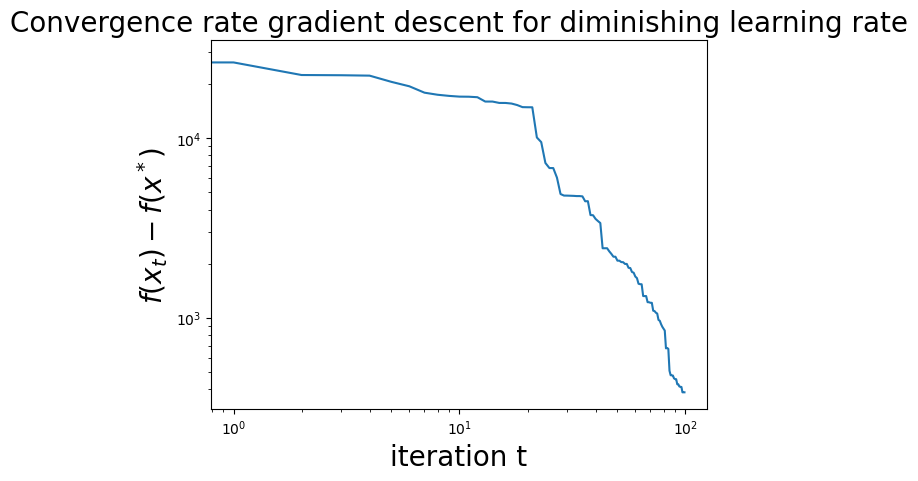

In [15]:
plt.title('Convergence rate gradient descent for diminishing learning rate', fontsize = 20)
plt.loglog(stocgd_objectives_dim_lr - best_objective)
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)

For this simulation, we choose a diminishing stepsize of the form
$\alpha_k = \frac{\beta}{\gamma + k}$ with $\beta = \frac{2}{c} >
\frac{1}{c\mu}$ and $\gamma$ selected such that
$\alpha_1 < \frac{\mu}{L M_G}$. We can observe a good convergence
behavior, with a smoother decrease and fewer fluctuations compared to
the constant stepsize case.

#### Increasing Batch Size

Running SGD with batch size 1...
SGD(0000/0000/9999): objective =   29921.32
SGD(0001/0001/9999): objective =   28234.86
SGD(0002/0002/9999): objective =   26123.60
SGD(0003/0003/9999): objective =   25686.42
SGD(0004/0004/9999): objective =   22058.54
SGD(0005/0005/9999): objective =   21610.64
SGD(0006/0006/9999): objective =   21336.54
SGD(0007/0007/9999): objective =   19921.03
SGD(0008/0008/9999): objective =   19824.59
SGD(0009/0009/9999): objective =   13932.48
SGD(0010/0010/9999): objective =   13653.96
SGD(0011/0011/9999): objective =   13621.20
SGD(0012/0012/9999): objective =   13273.44
SGD(0013/0013/9999): objective =   13226.55
SGD(0014/0014/9999): objective =   12918.56
SGD(0015/0015/9999): objective =    8127.58
SGD(0016/0016/9999): objective =    8129.78
SGD(0017/0017/9999): objective =    8125.20
SGD(0018/0018/9999): objective =    8106.27
SGD(0019/0019/9999): objective =    7498.59
SGD(0020/0020/9999): objective =    6045.79
SGD(0021/0021/9999): objective =    5553.94

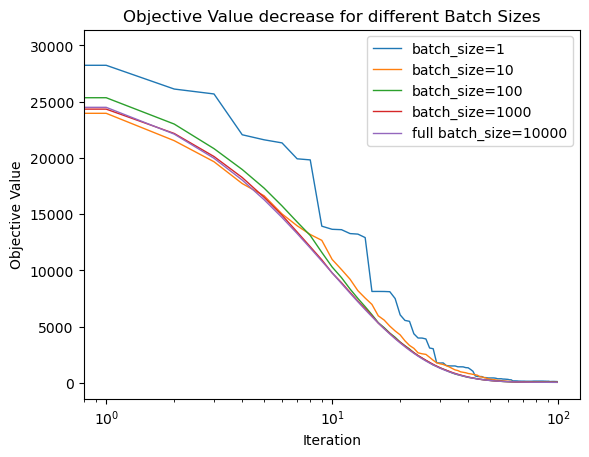

SGD: execution time=0.039 seconds


In [16]:
# Define the parameters of the algorithm.
nmax = 100
lr=0.05
batch_size_list = [1, 10,100, 1000,n]
objectives_dict = {}

# Initialization
x_initial = np.zeros(A.shape[1])

for batch_size in batch_size_list:
    # Start GD
    print(f"Running SGD with batch size {batch_size}...")
    stocgd_objectives, stocgd_iterates = stoc_gradient_descent(
        Y, A, x_initial, nmax, lr,batch_size)

    objectives_dict[batch_size] = stocgd_objectives

# Print result
for batch_size, objectives in objectives_dict.items():
        if batch_size== n:
              plt.plot(objectives, label=f"full batch_size={batch_size}", linewidth=1)
        else:      
            plt.plot(objectives, label=f"batch_size={batch_size}", linewidth=1)
plt.legend()
plt.xlabel("Iteration")
plt.xscale('log')
plt.ylabel("Objective Value")
plt.title("Objective Value decrease for different Batch Sizes")
plt.show()
print("SGD: execution time={t:.3f} seconds".format(t=execution_time))

Compare your results with the classic (full batch) gradient method.

The experiment demonstrates that the **batch_size = 1** curve is the most irregular: we could see plateaus and sudden drops, so the descent is quite noisy.The **mini-batch** curves (**10** and **100**) are much smoother and decrease more steadily.
They also reach low objective values quickly, with a more regular convergence behavior.
We could also observe that  **full-batch** curve (**1000**) is smooth as well, but here it does not look clearly faster than the mini-batch cases.
Hence, **mini-batch gradient descent** seems to give the best trade-off between speed and stability in this experiment.


## 2 - Support Vector Machine

In this section, we will implement a stochastic (sub)-gradient algorithm in order to solve the soft primal margin SVM training problem. Recall the problem:
$$
\displaystyle \min_{w,b} \frac{1}{2}\|w\|^2 + C\sum_{i=1}^{n} \max\{0,1-y_i(w^Tx_i+b)\} 
$$
where $C$ is a parameter. In the following, we will write $\theta=(w,b)$ where $w=(\theta_1,\ldots,\theta_d)$ and $b=\theta_{d+1}$.

Let us first import libraries

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.utils import shuffle

Then define a function to generate two clusters of 2D data point that we will try to separate using the SVM. The number of points generated is a parameter of the function.

In [18]:
def generatedata2(n):
    # n must be an even integer
    np.random.seed(0)
    mean1, cov1, n1 = [1, 5], [[1,1],[1,2]], int(n/2)  # n/2 samples of class 1
    x1 = np.random.multivariate_normal(mean1, cov1, n1)
    y1 = np.ones(n1, dtype=int)
    mean2, cov2, n2 = [2.5, 2.5], [[1,0],[0,1]], int(n/2) # n/2 samples of class -1
    x2 = np.random.multivariate_normal(mean2, cov2, n2)
    y2 = -np.ones(n2, dtype=int)
    x = np.concatenate((x1, x2), axis=0) # concatenate the samples
    y = np.concatenate((y1, y2))
    x,y = shuffle(x,y)
    
    return [x,y]

Let us now define a function that will plot the data and a function to plot the hyperplane (and the supporting hyperplanes) generated by the SVM and represented in the form of $\theta=(w,b)$ (meaning $w^Tx+b=0$).

In [19]:
def plotdata(x,y):
    for i in range(x.shape[0]):
        if y[i]==-1:
            cl='bo';
        else:
                cl='r+';
        plt.plot(x[i,0],x[i,1],cl);
    return

def plothyperplane(w,b,x):
    xx=np.linspace(x[:,0].min(),x[:,0].max(),100);
    #print(xx)
    yy=(-b-w[0]*xx)/w[1];
    yy1=yy+1/np.linalg.norm(w);
    yy2=yy-1/np.linalg.norm(w);
    #print(yy)
    plt.plot(xx,yy,'k-')
    plt.plot(xx,yy1,'g-')
    plt.plot(xx,yy2,'g-')
    return

Define first the function that computes the value of the SVM problem objective function at $\theta$.

In [20]:
def SVMobjective(x,y,d,C,theta):
    w = theta[0:d]
    b = theta[d]
    loss = 0.5 * np.linalg.norm(w)**2
    n= len(y)
    for i in range( n):
        loss += C * max(0, 1 - y[i] * (np.dot(w, x[i]) + b))
    return loss

Define now a new function that will take as parameters a batch of samples $(x_i,y_i)_{i=1,\ldots,batch size}$ and return a stochastic subgradient of the objective function at $\theta$ by considering only the terms of the batch. 

In [21]:
def minibatch_subgrad_svm(x_batch,y_batch,d,C,theta):
    w = theta[0:d] 
    b= theta[d]
    subgrad = np.concatenate((w,np.zeros(1)),axis=0)
    n= len(y_batch)
    for i in range(n):
        if  1 - y_batch[i] * (np.dot(w, x_batch[i]) + b) >= 0:
            subgrad -= C*y_batch[i] * np.concatenate((x_batch[i],np.ones(1)),axis=0)

    return subgrad

Use the above function to implement the following svm_SGD algorithm:

In [22]:
def svm_SGD(x,y,d,C,theta,batch_size,lr,nmax):
    
    thetas = [theta]
    objectives = []
    n= len(y)
    for epoch in range(nmax):
        for iter in range(int(len(y)/batch_size)):
            indices = np.random.choice(n, batch_size, replace=True)
            x_batch= x[indices,:]
            y_batch= y[indices]
            SVMgrad= minibatch_subgrad_svm(x_batch,y_batch,d,C,theta) 
        
            # update x through the gradient update
            theta -= lr* SVMgrad
                
            # store x and objective
            thetas.append(theta.copy())
            objective=SVMobjective(x,y,d,C,theta)
            objectives.append(objective)
            print("SGD({ep:04d}/{bi:04d}/{ti:04d}): objective = {l:10.2f}".format(ep=epoch,
                          bi=epoch, ti=len(y) - 1, l=objective))
    return objectives, thetas


SGD(0000/0000/0999): objective =  111215.37
SGD(0000/0000/0999): objective =  110694.75
SGD(0000/0000/0999): objective =  219593.93
SGD(0000/0000/0999): objective =   19986.73
SGD(0000/0000/0999): objective =    7916.88
SGD(0000/0000/0999): objective =    9306.21
SGD(0000/0000/0999): objective =    7271.56
SGD(0000/0000/0999): objective =    8327.11
SGD(0000/0000/0999): objective =    9379.64
SGD(0000/0000/0999): objective =    6679.80
SGD(0001/0001/0999): objective =    7838.65
SGD(0001/0001/0999): objective =    7320.58
SGD(0001/0001/0999): objective =    7637.04
SGD(0001/0001/0999): objective =    5859.93
SGD(0001/0001/0999): objective =    6095.07
SGD(0001/0001/0999): objective =    5986.33
SGD(0001/0001/0999): objective =    5592.24
SGD(0001/0001/0999): objective =    8671.37
SGD(0001/0001/0999): objective =   18800.66
SGD(0001/0001/0999): objective =    6071.82
SGD(0002/0002/0999): objective =    5674.43
SGD(0002/0002/0999): objective =    7851.30
SGD(0002/0002/0999): objective =

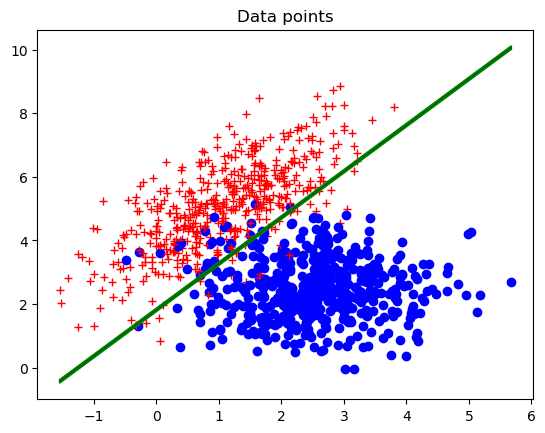

In [30]:
plt.close("all");

d=2
n=1000
C=10
nmax=100
lr=0.01
batch_size=100

[x,y]=generatedata2(n);

plt.figure(0);
plotdata(x,y);
plt.title("Data points")

theta_initial=np.empty([d+1])
theta_initial[:d]=np.zeros([2]);
theta_initial[d]=0

obj=np.empty(nmax);
objectives, thetas = svm_SGD(x,y,d,C,theta_initial,batch_size,lr,nmax)
predict=np.empty(n);
w=thetas[-1][:d]
b=thetas[-1][d]

error=0;
for j in range(n):
    predict[j]=np.sign(np.dot(x[j,:],w)+b);
    if y[j]!=predict[j]:
        error+=1;
plothyperplane(w,b,x);

#error
training_error=error*100/n
print('Training error=',training_error)


Text(0.5, 1.0, 'Objective Value for SVM')

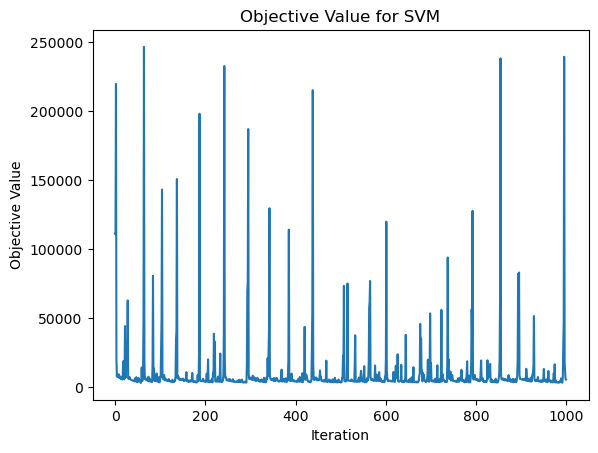

In [31]:
plt.figure(1);
plt.plot(range(len(objectives)),objectives)
plt.xlabel("Iteration")
plt.ylabel("Objective Value")
plt.title("Objective Value for SVM")

In [24]:
C_vector=[0.01,0.1,1,10,100]
training_errors=[]
objectives_list = []
for C in C_vector:
    objectives, thetas = svm_SGD(x,y,d,C,theta_initial,batch_size,lr,nmax)
    objectives_list.append(objectives)
    w=thetas[-1][:d]
    b=thetas[-1][d]
    error=0;
    predict=np.zeros(n)
    for j in range(n):
        predict[j]=np.sign(np.dot(x[j,:],w)+b);
        if y[j]!=predict[j]:
            error+=1;
    training_error=error*100/n
    training_errors.append(training_error)
    print(f"C={C}: Training error={training_error}%")


    

SGD(0000/0000/0999): objective =     254.89
SGD(0000/0000/0999): objective =     249.89
SGD(0000/0000/0999): objective =     244.99
SGD(0000/0000/0999): objective =     240.19
SGD(0000/0000/0999): objective =     235.50
SGD(0000/0000/0999): objective =     230.89
SGD(0000/0000/0999): objective =     226.38
SGD(0000/0000/0999): objective =     221.98
SGD(0000/0000/0999): objective =     217.65
SGD(0000/0000/0999): objective =     213.43
SGD(0001/0001/0999): objective =     209.30
SGD(0001/0001/0999): objective =     205.26
SGD(0001/0001/0999): objective =     201.31
SGD(0001/0001/0999): objective =     197.45
SGD(0001/0001/0999): objective =     193.66
SGD(0001/0001/0999): objective =     189.96
SGD(0001/0001/0999): objective =     186.34
SGD(0001/0001/0999): objective =     182.79
SGD(0001/0001/0999): objective =     179.31
SGD(0001/0001/0999): objective =     175.92
SGD(0002/0002/0999): objective =     172.61
SGD(0002/0002/0999): objective =     169.37
SGD(0002/0002/0999): objective =

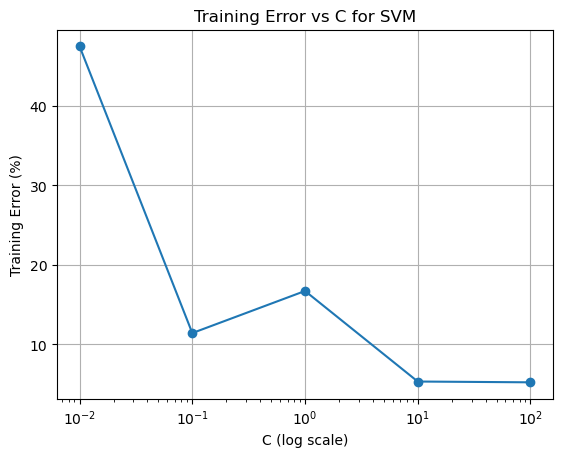

In [25]:
#   Training error for each C value is printed above
plt.figure(2);
plt.plot(C_vector, training_errors, marker='o')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Training Error (%)')
plt.title('Training Error vs C for SVM')
plt.grid()
plt.show()

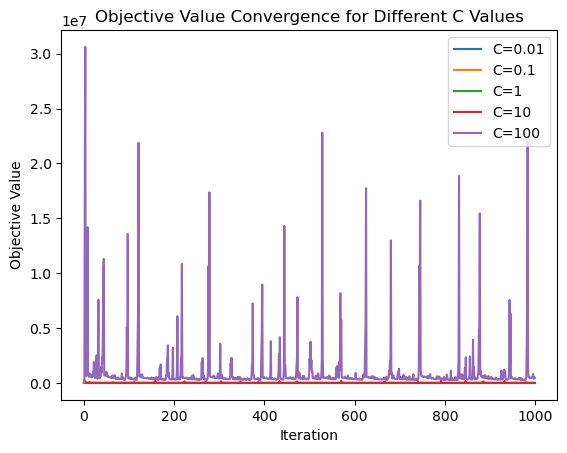

In [26]:
# Objective value convergence for different C values
plt.figure(3)
for i, C in enumerate(C_vector):
    plt.plot(objectives_list[i], label=f"C={C}")
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.title('Objective Value Convergence for Different C Values')
plt.legend()
plt.show()

The training error decreases as **C** increases, which is expected, since a larger **C** gives more weight to minimizing classification errors on the training set. However, the **objective value** curves show that for larger values of **C**, the optimization becomes less steady, with more visible peaks and oscillations. In contrast, smaller values of **C** lead to smoother and more stable convergence, but usually with a higher training error. 
